
# Analisis de reservas de Uber y cancelaciones

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

df=pd.read_csv("ncr_ride_bookings.csv")

Establecer formato de fecha y hora, agregamos una columna con la hora de la reservación como un entero y una columna con el día de la semana

In [3]:
df["Date"] = pd.to_datetime(df["Date"])
df["Hour"] = df["Time"].str[:2].astype(int)
df["DayOfWeek"] = df["Date"].dt.day_name()

## Porcentaje de cancelaciones por día y hora

Agrupamos

In [4]:
grouped = df.groupby(["DayOfWeek", "Hour"]).agg(
    total_rides=("Booking ID", "count"),
    driver_cancels=("Cancelled Rides by Driver", "sum"),
    customer_cancels=("Cancelled Rides by Customer", "sum")
).reset_index()

Generamos los pivot para conductores y clientes según el porcentaje de cancelación

In [6]:
# Calcular porcentajes
grouped["Cancel % Driver"] = 100 * grouped["driver_cancels"] / grouped["total_rides"]
grouped["Cancel % Customer"] = 100 * grouped["customer_cancels"] / grouped["total_rides"]

# Pivot para heatmap (driver)
pivot_driver = grouped.pivot(index="DayOfWeek", columns="Hour", values="Cancel % Driver")

# Pivot para heatmap (customer)
pivot_customer = grouped.pivot(index="DayOfWeek", columns="Hour", values="Cancel % Customer")


#Ordenamos los días
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
pivot_driver = pivot_driver.reindex(days_order)
pivot_customer = pivot_customer.reindex(days_order)

### Heatmaps

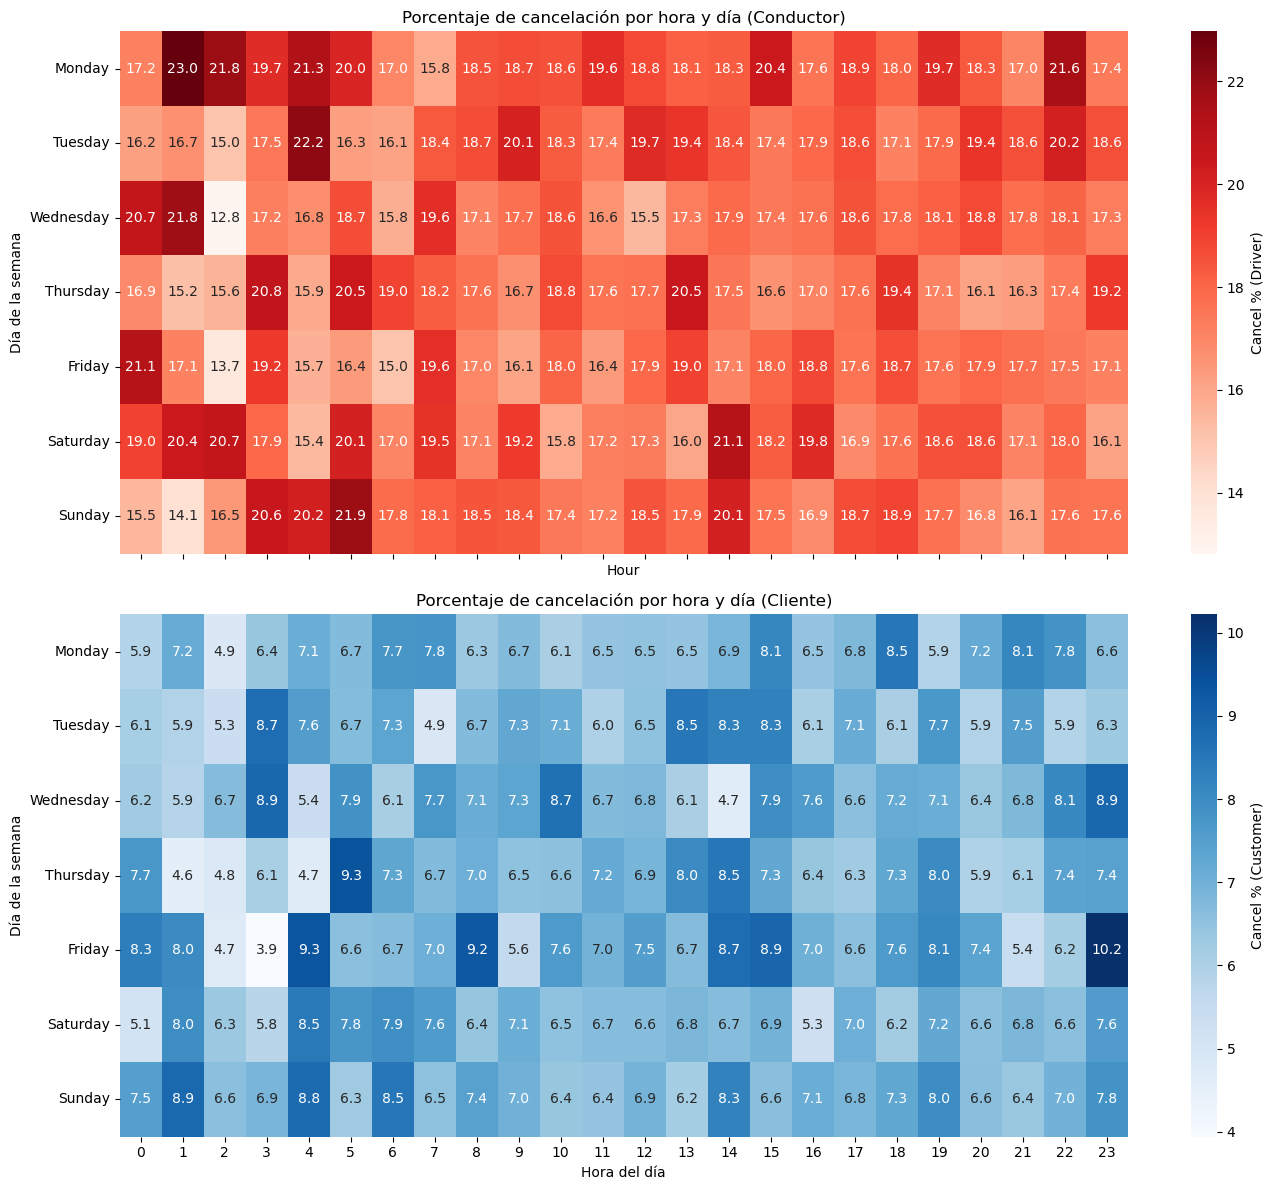

In [7]:
fig, axes = plt.subplots(2, 1, figsize=(14, 12), sharex=True)

sns.heatmap(pivot_driver, annot=True, fmt=".1f", cmap="Reds",
            cbar_kws={'label': 'Cancel % (Driver)'}, ax=axes[0])
axes[0].set_title("Porcentaje de cancelación por hora y día (Conductor)")
axes[0].set_ylabel("Día de la semana")

sns.heatmap(pivot_customer, annot=True, fmt=".1f", cmap="Blues",
            cbar_kws={'label': 'Cancel % (Customer)'}, ax=axes[1])
axes[1].set_title("Porcentaje de cancelación por hora y día (Cliente)")
axes[1].set_ylabel("Día de la semana")
axes[1].set_xlabel("Hora del día")

plt.tight_layout()
plt.show()

## Razones de cancelación


In [8]:
#Filtro de Cancelaciones

cancel_filter = (
    (df["Cancelled Rides by Customer"].fillna(0) > 0) |
    (df["Cancelled Rides by Driver"].fillna(0) > 0) |
    (df["Booking Status"] == "No Driver Found")
)
df_cancelled = df[cancel_filter].copy()

# Nos quedamos con las cancelaciones que tienen razón de cliente
df_customer_reasons = df_cancelled[df_cancelled["Reason for cancelling by Customer"].notna()]

# Agrupamos por día, hora y razón
grouped_reasons = df_customer_reasons.groupby(
    ["DayOfWeek", "Hour", "Reason for cancelling by Customer"]
).size().reset_index(name="Count")

# Calcular porcentaje dentro de cada (día, hora)
grouped_reasons["TotalInSlot"] = grouped_reasons.groupby(["DayOfWeek", "Hour"])["Count"].transform("sum")
grouped_reasons["Percent"] = 100 * grouped_reasons["Count"] / grouped_reasons["TotalInSlot"]

# Ver las primeras filas
grouped_reasons.head()

,DayOfWeek,Hour,Reason for cancelling by Customer,Count,TotalInSlot,Percent
0,Friday,0,AC is not working,3,15,20.000000
1,Friday,0,Driver asked to cancel,4,15,26.666667
2,Friday,0,Driver is not moving towards pickup location,4,15,26.666667
3,Friday,0,Wrong Address,4,15,26.666667
4,Friday,1,AC is not working,1,15,6.666667
